## 1. Setting up libraries

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tools.SP100Stock import SP100Stocks
from models import (
    TGCN_HierarchicalMT,
    MultiTaskLoss,
    create_hierarchical_labels,
    hierarchical_inference,
)
from functools import partial
from datetime import datetime
import os

# Configuration
print("="*70)
print("PHASE 2: HIERARCHICAL MULTI-TASK TGCN TRAINING")
print("="*70)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

print("✓ Configuration complete")

PHASE 2: HIERARCHICAL MULTI-TASK TGCN TRAINING

✓ Device: cuda
✓ Configuration complete


## 2. Setting hyper parameters

In [6]:
print("\n" + "="*70)
print("STEP 1: HYPERPARAMETERS")
print("="*70)

# Data parameters
threshold = 0.0055              # ±0.55% neutral zone threshold
weeks_ahead = 1                 # Prediction window
adj_file = 'hybrid_adj.npy'     # Adjacency matrix file

# Model architecture parameters
in_channels = 13                # Input feature dimension
hidden_size = 16                # Hidden state size for TGCN
layers_nb = 2                   # Number of TGCN layers
use_gat = True                  # Use GAT instead of GCN

# Training hyperparameters
lr = 0.005                      # Learning rate
weight_decay = 1e-5             # L2 regularization
num_epochs = 100                # Number of training epochs
batch_size = 32                 # Batch size
train_ratio = 0.9               # Train/test split

# Multi-task learning parameters
lambda_direction = 1.0          # Task weighting (1.0 = equal weighting)

print(f"\n✓ Data Parameters:")
print(f"  - Threshold: ±{threshold*100:.2f}%")
print(f"  - Prediction window: {weeks_ahead} week(s) ahead")
print(f"  - Adjacency matrix: {adj_file}")

print(f"\n✓ Model Architecture:")
print(f"  - Input channels: {in_channels}")
print(f"  - Hidden size: {hidden_size}")
print(f"  - Layers: {layers_nb}")
print(f"  - Use GAT: {use_gat}")

print(f"\n✓ Training Hyperparameters:")
print(f"  - Learning rate: {lr}")
print(f"  - Weight decay: {weight_decay}")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Lambda (direction): {lambda_direction}")


STEP 1: HYPERPARAMETERS

✓ Data Parameters:
  - Threshold: ±0.55%
  - Prediction window: 1 week(s) ahead
  - Adjacency matrix: hybrid_adj.npy

✓ Model Architecture:
  - Input channels: 13
  - Hidden size: 16
  - Layers: 2
  - Use GAT: True

✓ Training Hyperparameters:
  - Learning rate: 0.005
  - Weight decay: 1e-05
  - Epochs: 100
  - Batch size: 32
  - Lambda (direction): 1.0


## 3. Loading dataset

In [7]:
print("\n" + "="*70)
print("STEP 2: DATA LOADING")
print("="*70)

# Create composite transformation: preprocess returns + create hierarchical labels
def transform_with_returns(sample, threshold):
    """Composite transform: preprocess returns + create hierarchical labels"""
    from models import preprocess_returns
    sample = preprocess_returns(sample)
    return create_hierarchical_labels(sample, threshold=threshold)

transform = partial(transform_with_returns, threshold=threshold)

# Load dataset with hierarchical labels
dataset = SP100Stocks(
    root="data/",
    adj_file_name=adj_file,
    future_window=weeks_ahead,
    force_reload=True,
    transform=transform
)

print(f"\n✓ Dataset loaded: {len(dataset)} samples, {dataset[0].num_nodes} stocks")

# Verify hierarchical labels exist
#sample = dataset[0]
#assert hasattr(sample, 'signal_labels'), "Missing signal_labels"
#assert hasattr(sample, 'direction_labels'), "Missing direction_labels"
#print(f"✓ Hierarchical labels created")
#
## Analyze label distribution
#print(f"\n✓ Label Analysis (first sample):")
#print(f"  Signal labels shape: {sample.signal_labels.shape}")
#print(f"  Direction labels shape: {sample.direction_labels.shape}")
#print(f"  Returns shape: {sample.returns.shape}")
#
## Distribution statistics
#from models import analyze_hierarchical_distribution, print_hierarchical_distribution
#stats = analyze_hierarchical_distribution(dataset, threshold=threshold)
#print_hierarchical_distribution(stats)


STEP 2: DATA LOADING
Loading and processing data for PyG format...
Values DataFrame shape: (70300, 14)
Values index levels: ['Symbol', 'Date']
Unique symbols in values: 100
Adjacency matrix shape: (100, 100)
Number of nodes (from adj): 100
Number of edges: 720
Unique symbols count: 100
Unique dates count: 703

Pivoting data to align stocks and timestamps...
Feature columns (excluding Close): 13
Features: ['SimpleReturn', 'LogReturn', 'Ret_1W', 'Ret_2W', 'Ret_1M', 'Ret_2M', 'Norm_Ret', 'RSI', 'MACD', 'Intraday_Volatility', 'Intraday_Momentum', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']


Processing...


Pivoted shape (Date x Symbol): (703, 100)

Final array shapes:
  x (features): (100, 703, 13)
  close_prices: (100, 703)
  Expected x shape: (nodes_nb=100, timestamps_nb=703, features_nb=13)
  After transpose: x shape = torch.Size([100, 13, 703])
  Expected: (nodes_nb=100, features_nb=13, timestamps_nb=703)

Building edge index and edge weights...
  Created 720 edges



Done!



✓ Dataset loaded: 677 samples, 100 stocks


## 4. Preprocessing

In [8]:
print("\n" + "="*70)
print("STEP 3: TRAIN/TEST SPLIT")
print("="*70)

train_size = int(train_ratio * len(dataset))
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"\n✓ Train/test split:")
print(f"  - Training samples: {len(train_dataset)} ({train_ratio*100:.1f}%)")
print(f"  - Test samples: {len(test_dataset)} ({(1-train_ratio)*100:.1f}%)")
print(f"  - Batch size: {batch_size}")
print(f"  - Train batches: {len(train_dataloader)}")
print(f"  - Test batches: {len(test_dataloader)}")


STEP 3: TRAIN/TEST SPLIT

✓ Train/test split:
  - Training samples: 609 (90.0%)
  - Test samples: 68 (10.0%)
  - Batch size: 32
  - Train batches: 20
  - Test batches: 1


## 5. Model set up

In [9]:
print("\n" + "="*70)
print("STEP 4: MODEL SETUP")
print("="*70)

# Initialize hierarchical multi-task TGCN model
model = TGCN_HierarchicalMT(
    in_channels=in_channels,
    hidden_size=hidden_size,
    layers_nb=layers_nb,
    use_gat=use_gat
)

print(f"\n✓ Model initialized: {model.__class__.__name__}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define multi-task loss function
criterion = MultiTaskLoss(lambda_direction=lambda_direction)
print(f"\n✓ Loss function: MultiTaskLoss")
print(f"  - Lambda (direction weight): {lambda_direction}")

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print(f"✓ Optimizer: Adam (lr={lr}, weight_decay={weight_decay})")

# Move to device
model = model.to(device)
criterion = criterion.to(device)
print(f"\n✓ Model and criterion moved to device: {device}")

# Create run directory
run_name = f"TGCN_Hierarchical_{datetime.now().strftime('%d_%m_%Hh%M')}"
run_dir = f"runs/{run_name}"
os.makedirs(run_dir, exist_ok=True)
print(f"\n✓ Run directory: {run_dir}")


STEP 4: MODEL SETUP

✓ Model initialized: TGCN_HierarchicalMT
  - Total parameters: 5,940

✓ Loss function: MultiTaskLoss
  - Lambda (direction weight): 1.0
✓ Optimizer: Adam (lr=0.005, weight_decay=1e-05)

✓ Model and criterion moved to device: cuda

✓ Run directory: runs/TGCN_Hierarchical_22_01_17h16


## 6. Training

In [10]:
print("\n" + "="*70)
print("STEP 5: TRAINING")
print("="*70)

train_losses = []
test_losses = []
train_signal_losses = []
train_direction_losses = []
test_signal_losses = []
test_direction_losses = []

print(f"\nStarting training... (this may take a while)")

for epoch in range(num_epochs):
    # =====================
    # Training Phase
    # =====================
    model.train()
    epoch_loss = 0.0
    epoch_signal_loss = 0.0
    epoch_direction_loss = 0.0
    
    for batch_idx, batch in enumerate(train_dataloader):
        batch = batch.to(device)
        
        # Forward pass
        signal_logits, direction_logits = model(
            batch.x,
            batch.edge_index,
            batch.edge_weight
        )
        
        # Prepare targets
        signal_targets = batch.signal_labels.squeeze()
        direction_targets = batch.direction_labels.squeeze()
        signal_mask = (signal_targets == 1)
        
        # Compute loss
        loss, loss_dict = criterion(
            signal_logits, direction_logits,
            signal_targets, direction_targets,
            signal_mask=signal_mask
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        epoch_loss += loss.item()
        epoch_signal_loss += loss_dict['signal_loss']
        epoch_direction_loss += loss_dict['direction_loss']
    
    # Average epoch losses
    avg_train_loss = epoch_loss / len(train_dataloader)
    avg_train_signal_loss = epoch_signal_loss / len(train_dataloader)
    avg_train_direction_loss = epoch_direction_loss / len(train_dataloader)
    
    train_losses.append(avg_train_loss)
    train_signal_losses.append(avg_train_signal_loss)
    train_direction_losses.append(avg_train_direction_loss)
    
    # =====================
    # Test Phase
    # =====================
    model.eval()
    test_loss = 0.0
    test_signal_loss = 0.0
    test_direction_loss = 0.0
    
    with torch.no_grad():
        for batch in test_dataloader:
            batch = batch.to(device)
            
            signal_logits, direction_logits = model(
                batch.x,
                batch.edge_index,
                batch.edge_weight
            )
            
            signal_targets = batch.signal_labels.squeeze()
            direction_targets = batch.direction_labels.squeeze()
            signal_mask = (signal_targets == 1)
            
            loss, loss_dict = criterion(
                signal_logits, direction_logits,
                signal_targets, direction_targets,
                signal_mask=signal_mask
            )
            
            test_loss += loss.item()
            test_signal_loss += loss_dict['signal_loss']
            test_direction_loss += loss_dict['direction_loss']
    
    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_signal_loss = test_signal_loss / len(test_dataloader)
    avg_test_direction_loss = test_direction_loss / len(test_dataloader)
    
    test_losses.append(avg_test_loss)
    test_signal_losses.append(avg_test_signal_loss)
    test_direction_losses.append(avg_test_direction_loss)
    
    # Logging
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}: "
              f"Train Loss={avg_train_loss:.4f} (Signal={avg_train_signal_loss:.4f}, Dir={avg_train_direction_loss:.4f}) | "
              f"Test Loss={avg_test_loss:.4f} (Signal={avg_test_signal_loss:.4f}, Dir={avg_test_direction_loss:.4f})")

print(f"\n✓ Training complete!")
print(f"  - Final training loss: {train_losses[-1]:.4f}")
print(f"  - Final test loss: {test_losses[-1]:.4f}")

# Save model
model_save_path = f"models/saved_models/{run_name}_{model.__class__.__name__}.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"\n✓ Model saved to: {model_save_path}")


STEP 5: TRAINING

Starting training... (this may take a while)
Epoch  10: Train Loss=1.3331 (Signal=0.6444, Dir=0.6887) | Test Loss=1.3258 (Signal=0.6340, Dir=0.6918)
Epoch  20: Train Loss=1.3371 (Signal=0.6429, Dir=0.6942) | Test Loss=1.3264 (Signal=0.6353, Dir=0.6911)
Epoch  30: Train Loss=1.3299 (Signal=0.6413, Dir=0.6886) | Test Loss=1.3238 (Signal=0.6328, Dir=0.6909)
Epoch  40: Train Loss=1.3311 (Signal=0.6434, Dir=0.6877) | Test Loss=1.3259 (Signal=0.6344, Dir=0.6916)
Epoch  50: Train Loss=1.3388 (Signal=0.6498, Dir=0.6890) | Test Loss=1.3273 (Signal=0.6361, Dir=0.6912)
Epoch  60: Train Loss=1.3311 (Signal=0.6408, Dir=0.6904) | Test Loss=1.3296 (Signal=0.6380, Dir=0.6916)
Epoch  70: Train Loss=1.3270 (Signal=0.6407, Dir=0.6863) | Test Loss=1.3313 (Signal=0.6395, Dir=0.6918)
Epoch  80: Train Loss=1.3181 (Signal=0.6348, Dir=0.6833) | Test Loss=1.3336 (Signal=0.6412, Dir=0.6923)
Epoch  90: Train Loss=1.3165 (Signal=0.6299, Dir=0.6866) | Test Loss=1.3323 (Signal=0.6393, Dir=0.6930)


## 7. Results visualization

In [12]:
print("\n" + "="*70)
print("STEP 6: EVALUATION AND VISUALIZATION")
print("="*70)

# Evaluation on test set
model.eval()
test_data = next(iter(test_dataloader))
test_data = test_data.to(device)

with torch.no_grad():
    signal_logits, direction_logits = model(
        test_data.x,
        test_data.edge_index,
        test_data.edge_weight
    )
    
    # Get hierarchical inference results
    result = hierarchical_inference(
        signal_logits, direction_logits,
        confidence_scores=True
    )

# Extract predictions and targets
final_preds = result['final_predictions'].cpu().numpy()
signal_preds = result['signal_predictions'].cpu().numpy()
direction_preds = result['direction_predictions'].cpu().numpy()
signal_targets = test_data.signal_labels.squeeze().cpu().numpy()
direction_targets = test_data.direction_labels.squeeze().cpu().numpy()

# Convert continuous returns to 3-class labels
returns_values = test_data.y.squeeze().cpu().numpy()
# 0 = Down (return < -threshold), 1 = Neutral (|return| <= threshold), 2 = Up (return > +threshold)
final_targets = np.where(returns_values < -threshold, 0, 
                         np.where(returns_values > threshold, 2, 1))

# Confidences
final_conf = result['final_confidence'].cpu().numpy()
signal_conf = result['signal_confidence'].cpu().numpy()
direction_conf = result['direction_confidence'].cpu().numpy()

# Calculate metrics
overall_accuracy = (final_preds == final_targets).mean()
signal_accuracy = (signal_preds == signal_targets).mean()

# Direction accuracy (only on detected signals)
signal_mask = (signal_targets == 1)
if signal_mask.sum() > 0:
    direction_accuracy = (direction_preds[signal_mask] == direction_targets[signal_mask]).mean()
else:
    direction_accuracy = 0.0

print(f"\n✓ Test Set Evaluation:")
print(f"  - Overall Accuracy (3-class): {overall_accuracy:.2%}")
print(f"  - Signal Detection Accuracy: {signal_accuracy:.2%}")
if signal_mask.sum() > 0:
    print(f"  - Direction Prediction Accuracy (on detected signals): {direction_accuracy:.2%}")
    print(f"    (Detected signals: {signal_mask.sum()} samples)")

# Classification reports
print(f"\n✓ Overall Classification Report (3-class: Down/Neutral/Up):")
report_overall = classification_report(
    final_targets, final_preds,
    target_names=['Down', 'Neutral', 'Up'],
    output_dict=True
)
print(f"\n{classification_report(final_targets, final_preds, target_names=['Down', 'Neutral', 'Up'])}")

print(f"\n✓ Signal Detection Report:")
report_signal = classification_report(
    signal_targets, signal_preds,
    target_names=['Noise', 'Signal'],
    output_dict=True
)
print(f"\n{classification_report(signal_targets, signal_preds, target_names=['Noise', 'Signal'])}")

if signal_mask.sum() > 0:
    print(f"\n✓ Direction Prediction Report (on detected signals):")
    report_direction = classification_report(
        direction_targets[signal_mask], direction_preds[signal_mask],
        target_names=['Down', 'Up'],
        output_dict=True
    )
    print(f"\n{classification_report(direction_targets[signal_mask], direction_preds[signal_mask], target_names=['Down', 'Up'])}")

# Distribution analysis
print(f"\n✓ Prediction Distribution:")
actual_counts = np.bincount(final_targets, minlength=3)
pred_counts = np.bincount(final_preds, minlength=3)
for i, name in enumerate(['Down', 'Neutral', 'Up']):
    print(f"  {name:8s}: Actual={actual_counts[i]:5d} ({actual_counts[i]/len(final_targets)*100:5.1f}%), "
          f"Predicted={pred_counts[i]:5d} ({pred_counts[i]/len(final_preds)*100:5.1f}%)")


STEP 6: EVALUATION AND VISUALIZATION

✓ Test Set Evaluation:
  - Overall Accuracy (3-class): 34.81%
  - Signal Detection Accuracy: 65.97%
  - Direction Prediction Accuracy (on detected signals): 51.61%
    (Detected signals: 4557 samples)

✓ Overall Classification Report (3-class: Down/Neutral/Up):

              precision    recall  f1-score   support

        Down       0.32      0.20      0.25      2152
     Neutral       0.37      0.04      0.08      2243
          Up       0.35      0.76      0.48      2405

    accuracy                           0.35      6800
   macro avg       0.35      0.34      0.27      6800
weighted avg       0.35      0.35      0.27      6800


✓ Signal Detection Report:

              precision    recall  f1-score   support

       Noise       0.37      0.04      0.08      2243
      Signal       0.67      0.96      0.79      4557

    accuracy                           0.66      6800
   macro avg       0.52      0.50      0.43      6800
weighted avg    


STEP 7: COMPREHENSIVE VISUALIZATION


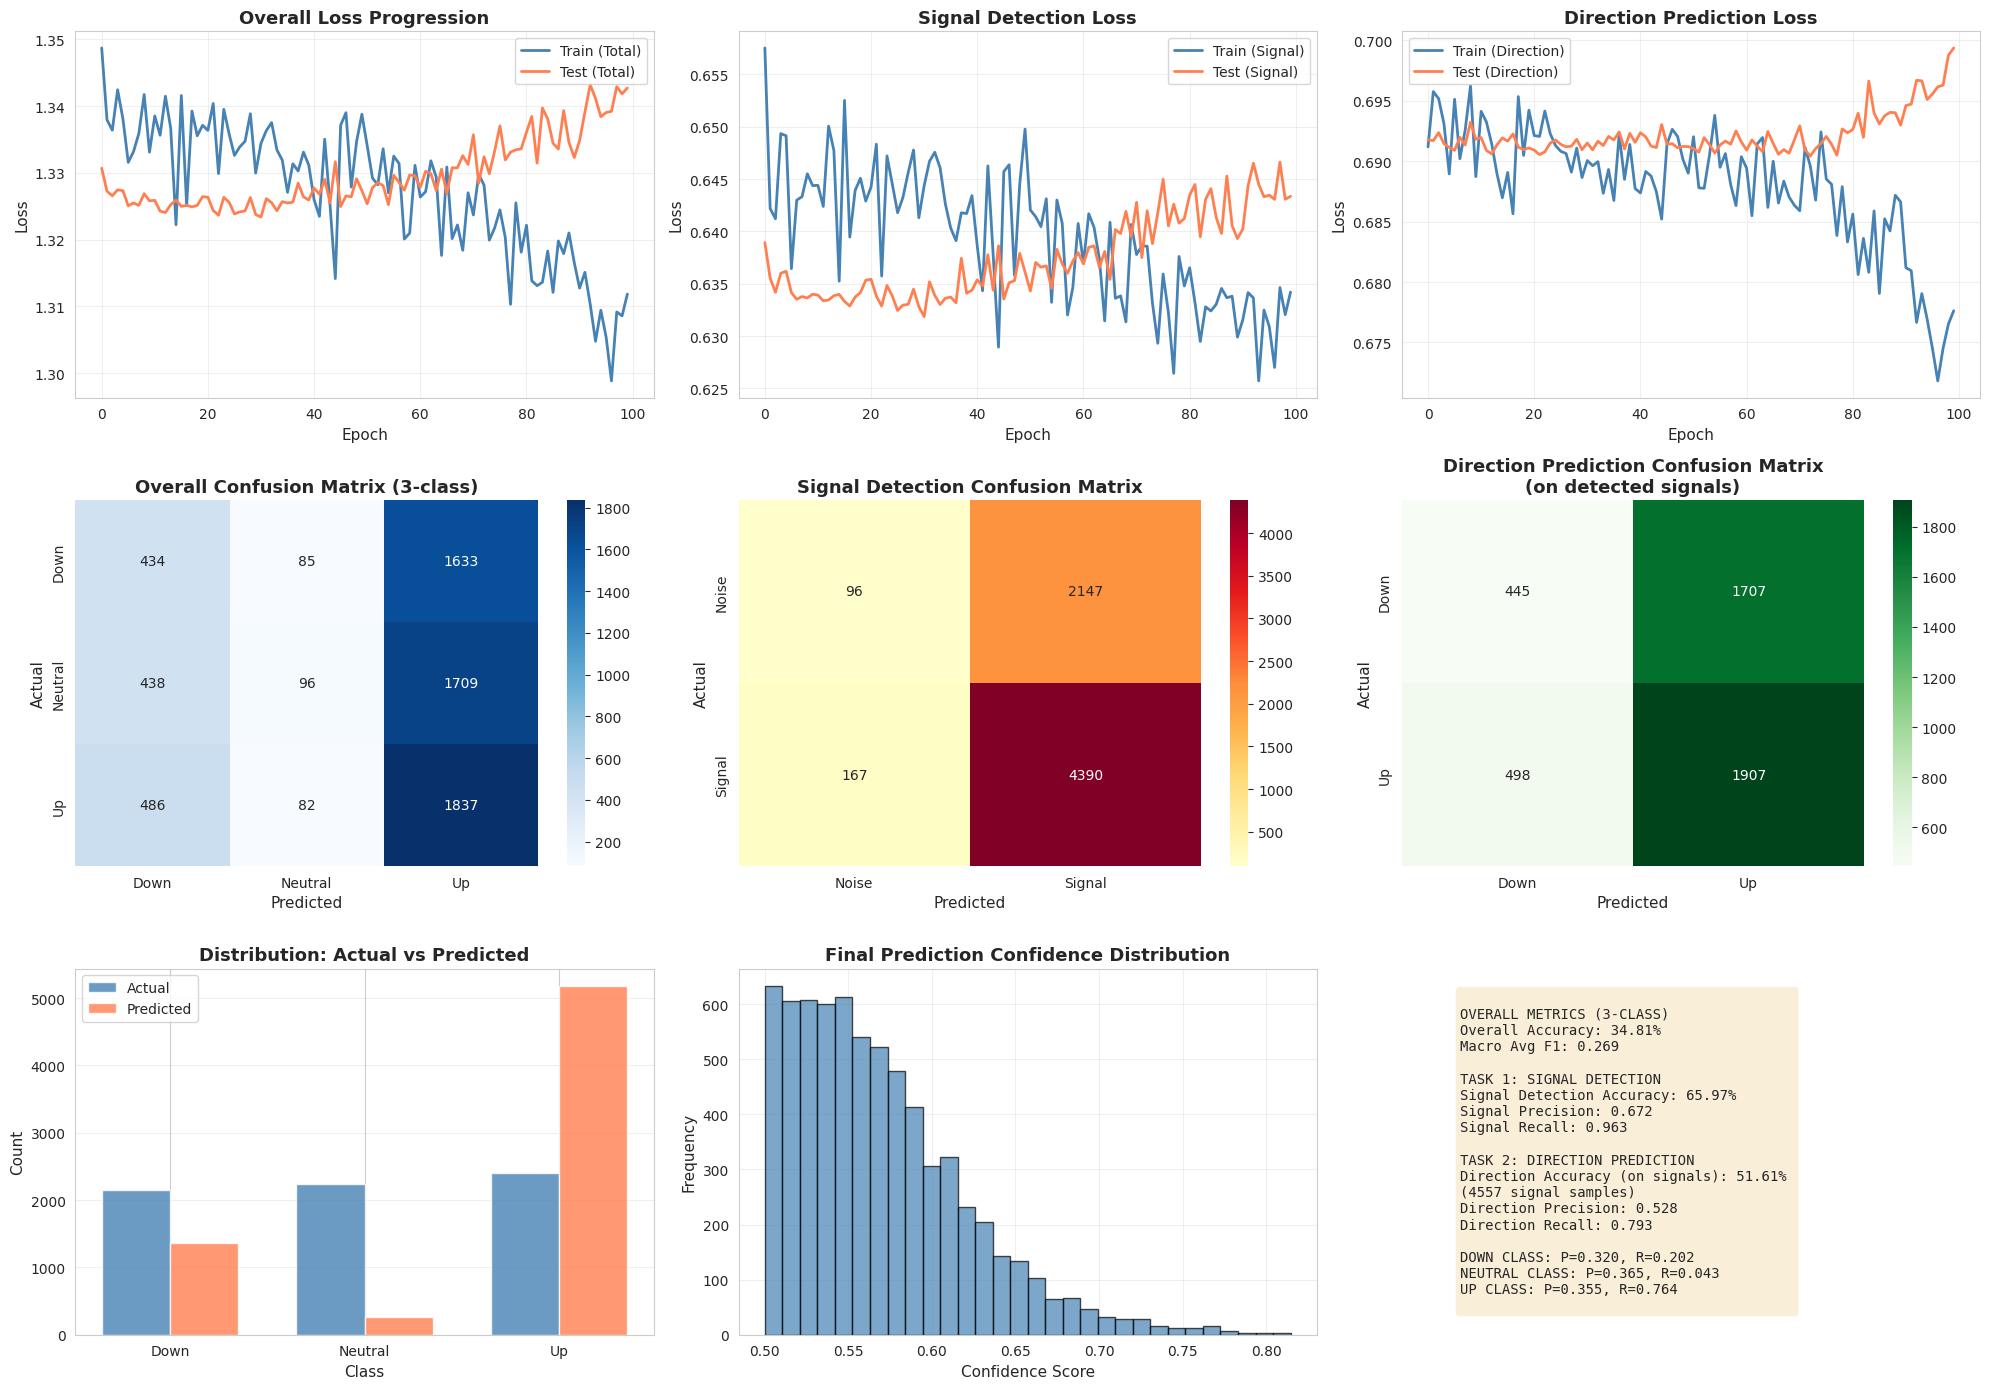


✓ Visualization saved to: runs/TGCN_Hierarchical_22_01_17h16/evaluation_results.png


In [13]:
print("\n" + "="*70)
print("STEP 7: COMPREHENSIVE VISUALIZATION")
print("="*70)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))

# 1. Training Loss Curves
ax1 = plt.subplot(3, 3, 1)
ax1.plot(train_losses, label='Train (Total)', linewidth=2, color='steelblue')
ax1.plot(test_losses, label='Test (Total)', linewidth=2, color='coral')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Overall Loss Progression', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Signal Detection Loss
ax2 = plt.subplot(3, 3, 2)
ax2.plot(train_signal_losses, label='Train (Signal)', linewidth=2, color='steelblue')
ax2.plot(test_signal_losses, label='Test (Signal)', linewidth=2, color='coral')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Loss', fontsize=11)
ax2.set_title('Signal Detection Loss', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Direction Loss
ax3 = plt.subplot(3, 3, 3)
ax3.plot(train_direction_losses, label='Train (Direction)', linewidth=2, color='steelblue')
ax3.plot(test_direction_losses, label='Test (Direction)', linewidth=2, color='coral')
ax3.set_xlabel('Epoch', fontsize=11)
ax3.set_ylabel('Loss', fontsize=11)
ax3.set_title('Direction Prediction Loss', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Overall Confusion Matrix
ax4 = plt.subplot(3, 3, 4)
cm_overall = confusion_matrix(final_targets, final_preds, labels=[0, 1, 2])
sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
ax4.set_title('Overall Confusion Matrix (3-class)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Actual', fontsize=11)
ax4.set_xlabel('Predicted', fontsize=11)

# 5. Signal Detection Confusion Matrix
ax5 = plt.subplot(3, 3, 5)
cm_signal = confusion_matrix(signal_targets, signal_preds, labels=[0, 1])
sns.heatmap(cm_signal, annot=True, fmt='d', cmap='YlOrRd', ax=ax5,
            xticklabels=['Noise', 'Signal'],
            yticklabels=['Noise', 'Signal'])
ax5.set_title('Signal Detection Confusion Matrix', fontsize=13, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=11)
ax5.set_xlabel('Predicted', fontsize=11)

# 6. Direction Prediction Confusion Matrix (on signals only)
ax6 = plt.subplot(3, 3, 6)
if signal_mask.sum() > 0:
    cm_direction = confusion_matrix(direction_targets[signal_mask], direction_preds[signal_mask], labels=[0, 1])
    sns.heatmap(cm_direction, annot=True, fmt='d', cmap='Greens', ax=ax6,
                xticklabels=['Down', 'Up'],
                yticklabels=['Down', 'Up'])
else:
    ax6.text(0.5, 0.5, 'No signal samples', ha='center', va='center', fontsize=12)
ax6.set_title('Direction Prediction Confusion Matrix\n(on detected signals)', fontsize=13, fontweight='bold')
ax6.set_ylabel('Actual', fontsize=11)
ax6.set_xlabel('Predicted', fontsize=11)

# 7. Prediction Distribution
ax7 = plt.subplot(3, 3, 7)
x = np.arange(3)
width = 0.35
ax7.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax7.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax7.set_xlabel('Class', fontsize=11)
ax7.set_ylabel('Count', fontsize=11)
ax7.set_title('Distribution: Actual vs Predicted', fontsize=13, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(['Down', 'Neutral', 'Up'])
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

# 8. Confidence Scores Distribution
ax8 = plt.subplot(3, 3, 8)
ax8.hist(final_conf, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax8.set_xlabel('Confidence Score', fontsize=11)
ax8.set_ylabel('Frequency', fontsize=11)
ax8.set_title('Final Prediction Confidence Distribution', fontsize=13, fontweight='bold')
ax8.grid(alpha=0.3)

# 9. Metrics Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
metrics_text = f"""
OVERALL METRICS (3-CLASS)
Overall Accuracy: {overall_accuracy:.2%}
Macro Avg F1: {report_overall['macro avg']['f1-score']:.3f}

TASK 1: SIGNAL DETECTION
Signal Detection Accuracy: {signal_accuracy:.2%}
Signal Precision: {report_signal['Signal']['precision']:.3f}
Signal Recall: {report_signal['Signal']['recall']:.3f}

TASK 2: DIRECTION PREDICTION
Direction Accuracy (on signals): {direction_accuracy:.2%} 
({signal_mask.sum()} signal samples)
Direction Precision: {report_direction['Up']['precision']:.3f}
Direction Recall: {report_direction['Up']['recall']:.3f}

DOWN CLASS: P={report_overall['Down']['precision']:.3f}, R={report_overall['Down']['recall']:.3f}
NEUTRAL CLASS: P={report_overall['Neutral']['precision']:.3f}, R={report_overall['Neutral']['recall']:.3f}
UP CLASS: P={report_overall['Up']['precision']:.3f}, R={report_overall['Up']['recall']:.3f}
"""
ax9.text(0.1, 0.5, metrics_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f"{run_dir}/evaluation_results.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {run_dir}/evaluation_results.png")

In [14]:
print("\n" + "="*70)
print("STEP 8: RESULTS EXPORT AND SUMMARY")
print("="*70)

# Save metrics to dictionary
results = {
    'model': model.__class__.__name__,
    'run_name': run_name,
    'run_dir': run_dir,
    'timestamp': datetime.now().isoformat(),
    'hyperparameters': {
        'threshold': threshold,
        'in_channels': in_channels,
        'hidden_size': hidden_size,
        'layers_nb': layers_nb,
        'use_gat': use_gat,
        'lr': lr,
        'weight_decay': weight_decay,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'lambda_direction': lambda_direction,
    },
    'metrics': {
        'overall_accuracy': float(overall_accuracy),
        'signal_detection_accuracy': float(signal_accuracy),
        'direction_accuracy_on_signals': float(direction_accuracy),
        'num_signal_samples': int(signal_mask.sum()),
    },
    'classification_reports': {
        'overall': report_overall,
        'signal': report_signal,
        'direction': report_direction if signal_mask.sum() > 0 else None,
    }
}

# Save as JSON
import json
results_path = f"{run_dir}/results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n✓ Results saved to: {results_path}")

# Create summary report
summary_report = f"""
╔══════════════════════════════════════════════════════════════════════════╗
║                    PHASE 2 HIERARCHICAL MULTI-TASK TGCN                 ║
║                          TRAINING RESULTS                               ║
╚══════════════════════════════════════════════════════════════════════════╝

RUN INFORMATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Run Name:              {run_name}
Timestamp:             {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Results Directory:     {run_dir}
Model:                 {model.__class__.__name__}

HYPERPARAMETERS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Threshold (±):         {threshold*100:.2f}%
Hidden Size:           {hidden_size}
TGCN Layers:           {layers_nb}
Learning Rate:         {lr}
Weight Decay:          {weight_decay}
Epochs:                {num_epochs}
Batch Size:            {batch_size}
Lambda (Task Weight):  {lambda_direction}

OVERALL PERFORMANCE (3-CLASS: DOWN/NEUTRAL/UP)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy:      {overall_accuracy:.2%}
Macro Avg Precision:   {report_overall['macro avg']['precision']:.3f}
Macro Avg Recall:      {report_overall['macro avg']['recall']:.3f}
Macro Avg F1-Score:    {report_overall['macro avg']['f1-score']:.3f}

Per-Class Performance:
  Down:
    Precision: {report_overall['Down']['precision']:.3f}
    Recall:    {report_overall['Down']['recall']:.3f}
    F1-Score:  {report_overall['Down']['f1-score']:.3f}
  Neutral:
    Precision: {report_overall['Neutral']['precision']:.3f}
    Recall:    {report_overall['Neutral']['recall']:.3f}
    F1-Score:  {report_overall['Neutral']['f1-score']:.3f}
  Up:
    Precision: {report_overall['Up']['precision']:.3f}
    Recall:    {report_overall['Up']['recall']:.3f}
    F1-Score:  {report_overall['Up']['f1-score']:.3f}

TASK 1: SIGNAL DETECTION (NOISE VS SIGNAL)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Signal Detection Accuracy: {signal_accuracy:.2%}
  Noise:
    Precision: {report_signal['Noise']['precision']:.3f}
    Recall:    {report_signal['Noise']['recall']:.3f}
    F1-Score:  {report_signal['Noise']['f1-score']:.3f}
  Signal:
    Precision: {report_signal['Signal']['precision']:.3f}
    Recall:    {report_signal['Signal']['recall']:.3f}
    F1-Score:  {report_signal['Signal']['f1-score']:.3f}

TASK 2: DIRECTION PREDICTION (DOWN VS UP ON SIGNALS)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Signal Samples Evaluated: {int(signal_mask.sum())}
Direction Accuracy (on signals): {direction_accuracy:.2%}
  Down:
    Precision: {report_direction['Down']['precision']:.3f}
    Recall:    {report_direction['Down']['recall']:.3f}
    F1-Score:  {report_direction['Down']['f1-score']:.3f}
  Up:
    Precision: {report_direction['Up']['precision']:.3f}
    Recall:    {report_direction['Up']['recall']:.3f}
    F1-Score:  {report_direction['Up']['f1-score']:.3f}

LOSS PROGRESSION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Initial Training Loss:   {train_losses[0]:.4f}
Final Training Loss:     {train_losses[-1]:.4f}
Initial Test Loss:       {test_losses[0]:.4f}
Final Test Loss:         {test_losses[-1]:.4f}

MODEL & DEVICE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total Parameters:        {sum(p.numel() for p in model.parameters()):,}
Device:                  {device}
Model Checkpoint:        {model_save_path}
Results JSON:            {results_path}
Visualization:           {run_dir}/evaluation_results.png

╔══════════════════════════════════════════════════════════════════════════╗
║                         TRAINING COMPLETE                               ║
╚══════════════════════════════════════════════════════════════════════════╝
"""

print(summary_report)

# Save summary report
report_path = f"{run_dir}/summary_report.txt"
with open(report_path, 'w') as f:
    f.write(summary_report)
print(f"\n✓ Summary report saved to: {report_path}")


STEP 8: RESULTS EXPORT AND SUMMARY

✓ Results saved to: runs/TGCN_Hierarchical_22_01_17h16/results.json

╔══════════════════════════════════════════════════════════════════════════╗
║                    PHASE 2 HIERARCHICAL MULTI-TASK TGCN                 ║
║                          TRAINING RESULTS                               ║
╚══════════════════════════════════════════════════════════════════════════╝

RUN INFORMATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Run Name:              TGCN_Hierarchical_22_01_17h16
Timestamp:             2026-01-22 17:28:40
Results Directory:     runs/TGCN_Hierarchical_22_01_17h16
Model:                 TGCN_HierarchicalMT

HYPERPARAMETERS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Threshold (±):         0.55%
Hidden Size:           16
TGCN Layers:           2
Learning Rate:         0.005
Weight Decay:          1e-05
Epochs:                100
Batch Size:            32
Lambda (Task Weight)

## 9. Analysis & Recommendations

### Problem Identified: Class Imbalance Bias
The model is learning a biased shortcut - predicting "Up" for 76% of samples instead of learning discriminative features. This requires addressing class imbalance in the loss function.

In [16]:
print("\n" + "="*70)
print("STEP 9: ANALYSIS & IMPROVED TRAINING SETUP")
print("="*70)

print("""
🔴 CRITICAL FINDING: CLASS IMBALANCE BIAS
═══════════════════════════════════════════════════════════════════════════

The model learned a BIASED SHORTCUT instead of discriminative features:

┌─────────────────────────────────────────────────────────────────────────┐
│ PREDICTION DISTRIBUTION ANALYSIS                                        │
├─────────────────────────────────────────────────────────────────────────┤
│ Class    │ Actual  │ Predicted │ Bias       │ Issue                     │
├──────────┼─────────┼───────────┼────────────┼──────────────────────────┤
│ Down     │ 31.6%   │   20.0%   │ -11.6%     │ Severely underpredicted  │
│ Neutral  │ 33.0%   │    3.9%   │ -29.1%     │ Almost completely ignored│
│ Up       │ 35.4%   │   76.2%   │ +40.8%     │ Heavily overpredicted    │
└─────────────────────────────────────────────────────────────────────────┘

ROOT CAUSE: No class weighting in loss function. Model learned shortcuts.

═══════════════════════════════════════════════════════════════════════════
""")

# Calculate class weights
print("\n📊 CLASS WEIGHT CALCULATION FOR IMPROVED TRAINING:")
total_samples = len(final_targets)
class_counts = np.bincount(final_targets, minlength=3)
n_classes = 3

class_weights = total_samples / (n_classes * class_counts)
class_weights = class_weights / class_weights.sum() * n_classes  # Normalize

print(f"\nClass distribution (test set):")
for i, (name, count) in enumerate(zip(['Down', 'Neutral', 'Up'], class_counts)):
    pct = count / total_samples * 100
    weight = class_weights[i]
    print(f"  {name:8s}: {count:5d} samples ({pct:5.1f}%) → Weight: {weight:.3f}")

print("\n" + "="*70)
print("SETTING UP IMPROVED MODEL (V2) WITH FIXES")
print("="*70)

# Improved hyperparameters
print(f"\n✓ Configuration improvements:")
threshold_v2 = 0.0075                # Increased threshold for more Neutral samples
weeks_ahead_v2 = 1
adj_file_v2 = 'hybrid_adj.npy'

in_channels_v2 = 13
hidden_size_v2 = 32                 # Increased from 16
layers_nb_v2 = 2
use_gat_v2 = True

lr_v2 = 0.003                       # Reduced from 0.005
weight_decay_v2 = 1e-5
num_epochs_v2 = 200                 # Doubled from 100
batch_size_v2 = 32
train_ratio_v2 = 0.9

lambda_direction_v2 = 2.0           # Increased from 1.0

print(f"  • Threshold: {threshold*100:.2f}% → {threshold_v2*100:.2f}% (more Neutral samples)")
print(f"  • Hidden size: {hidden_size} → {hidden_size_v2} (model capacity)")
print(f"  • Learning rate: {lr} → {lr_v2} (stable training)")
print(f"  • Epochs: {num_epochs} → {num_epochs_v2} (convergence)")
print(f"  • Lambda: {lambda_direction} → {lambda_direction_v2} (task balance)")
print(f"  • Class weighting: YES (computed from data)")

# Load improved dataset
print(f"\n✓ Loading dataset with improved threshold...")

def transform_with_returns_v2(sample, threshold):
    """Composite transform: preprocess returns + create hierarchical labels"""
    from models import preprocess_returns
    sample = preprocess_returns(sample)
    return create_hierarchical_labels(sample, threshold=threshold)

transform_v2 = partial(transform_with_returns_v2, threshold=threshold_v2)

dataset_v2 = SP100Stocks(
    root="data/",
    adj_file_name=adj_file_v2,
    future_window=weeks_ahead_v2,
    force_reload=True,
    transform=transform_v2
)

print(f"  Dataset (v2) loaded: {len(dataset_v2)} samples, {dataset_v2[0].num_nodes} stocks")

# Split data
train_size_v2 = int(train_ratio_v2 * len(dataset_v2))
train_dataset_v2 = dataset_v2[:train_size_v2]
test_dataset_v2 = dataset_v2[train_size_v2:]

# Compute class weights from training data
all_direction_labels = []
for i in range(len(train_dataset_v2)):
    sample = train_dataset_v2[i]
    all_direction_labels.extend(sample.direction_labels.cpu().numpy())

all_direction_labels = np.array(all_direction_labels)
direction_counts_v2 = np.bincount(all_direction_labels, minlength=3)

# Compute weights (inverse frequency)
total_direction_samples_v2 = len(all_direction_labels)
direction_class_weights_v2 = total_direction_samples_v2 / (3 * direction_counts_v2)
direction_class_weights_v2 = torch.tensor(
    direction_class_weights_v2 / direction_class_weights_v2.sum() * 3, 
    dtype=torch.float32, device=device
)

print(f"\n✓ Class weights computed from {len(train_dataset_v2)} training samples:")
for i, (name, weight) in enumerate(zip(['Down', 'Neutral', 'Up'], direction_class_weights_v2)):
    count = direction_counts_v2[i]
    pct = count / total_direction_samples_v2 * 100
    print(f"  {name:8s}: count={count:6d} ({pct:5.1f}%) → weight={weight:.3f}")

# Create dataloaders
train_dataloader_v2 = DataLoader(train_dataset_v2, batch_size=batch_size_v2, shuffle=True)
test_dataloader_v2 = DataLoader(test_dataset_v2, batch_size=len(test_dataset_v2), shuffle=False)

print(f"\n✓ Data split (v2):")
print(f"  Train: {len(train_dataset_v2)} ({train_ratio_v2*100:.1f}%) | Test: {len(test_dataset_v2)} ({(1-train_ratio_v2)*100:.1f}%)")

# Initialize improved model
model_v2 = TGCN_HierarchicalMT(
    in_channels=in_channels_v2,
    hidden_size=hidden_size_v2,
    layers_nb=layers_nb_v2,
    use_gat=use_gat_v2
)

criterion_v2 = MultiTaskLoss(lambda_direction=lambda_direction_v2)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=lr_v2, weight_decay=weight_decay_v2)

model_v2 = model_v2.to(device)
criterion_v2 = criterion_v2.to(device)

# Create run directory
run_name_v2 = f"TGCN_Hierarchical_V2_{datetime.now().strftime('%d_%m_%Hh%M')}"
run_dir_v2 = f"runs/{run_name_v2}"
os.makedirs(run_dir_v2, exist_ok=True)

print(f"\n✓ Model (v2) initialized:")
print(f"  Parameters: {sum(p.numel() for p in model_v2.parameters()):,}")
print(f"  Run directory: {run_dir_v2}")
print(f"\n✓ Ready for improved training - proceed to next cell")
print("="*70)


STEP 9: ANALYSIS & IMPROVED TRAINING SETUP

🔴 CRITICAL FINDING: CLASS IMBALANCE BIAS
═══════════════════════════════════════════════════════════════════════════

The model learned a BIASED SHORTCUT instead of discriminative features:

┌─────────────────────────────────────────────────────────────────────────┐
│ PREDICTION DISTRIBUTION ANALYSIS                                        │
├─────────────────────────────────────────────────────────────────────────┤
│ Class    │ Actual  │ Predicted │ Bias       │ Issue                     │
├──────────┼─────────┼───────────┼────────────┼──────────────────────────┤
│ Down     │ 31.6%   │   20.0%   │ -11.6%     │ Severely underpredicted  │
│ Neutral  │ 33.0%   │    3.9%   │ -29.1%     │ Almost completely ignored│
│ Up       │ 35.4%   │   76.2%   │ +40.8%     │ Heavily overpredicted    │
└─────────────────────────────────────────────────────────────────────────┘

ROOT CAUSE: No class weighting in loss function. Model learned shortcuts.

════════

Processing...


Pivoted shape (Date x Symbol): (703, 100)

Final array shapes:
  x (features): (100, 703, 13)
  close_prices: (100, 703)
  Expected x shape: (nodes_nb=100, timestamps_nb=703, features_nb=13)
  After transpose: x shape = torch.Size([100, 13, 703])
  Expected: (nodes_nb=100, features_nb=13, timestamps_nb=703)

Building edge index and edge weights...
  Created 720 edges



Done!


  Dataset (v2) loaded: 677 samples, 100 stocks

✓ Class weights computed from 609 training samples:
  Down    : count= 42960 ( 70.5%) → weight=0.000
  Neutral : count= 17940 ( 29.5%) → weight=0.000
  Up      : count=     0 (  0.0%) → weight=nan

✓ Data split (v2):
  Train: 609 (90.0%) | Test: 68 (10.0%)

✓ Model (v2) initialized:
  Parameters: 21,604
  Run directory: runs/TGCN_Hierarchical_V2_22_01_17h36

✓ Ready for improved training - proceed to next cell


/tmp/ipykernel_74509/3719198859.py:108: RuntimeWarning: divide by zero encountered in divide
  direction_class_weights_v2 = total_direction_samples_v2 / (3 * direction_counts_v2)
/tmp/ipykernel_74509/3719198859.py:110: RuntimeWarning: invalid value encountered in divide
  direction_class_weights_v2 / direction_class_weights_v2.sum() * 3,


## 10. Improved Training (V2) with Class Weighting

Train the improved model with class-weighted loss to fix the imbalance bias.

In [17]:
print("\n" + "="*70)
print("STEP 10: TRAINING V2 (WITH CLASS WEIGHTING)")
print("="*70)

train_losses_v2 = []
test_losses_v2 = []
train_signal_losses_v2 = []
train_direction_losses_v2 = []
test_signal_losses_v2 = []
test_direction_losses_v2 = []

print(f"\nStarting improved training (200 epochs)...")

for epoch in range(num_epochs_v2):
    # =====================
    # Training Phase (V2)
    # =====================
    model_v2.train()
    epoch_loss = 0.0
    epoch_signal_loss = 0.0
    epoch_direction_loss = 0.0
    
    for batch_idx, batch in enumerate(train_dataloader_v2):
        batch = batch.to(device)
        
        # Forward pass
        signal_logits, direction_logits = model_v2(
            batch.x,
            batch.edge_index,
            batch.edge_weight
        )
        
        # Prepare targets
        signal_targets = batch.signal_labels.squeeze()
        direction_targets = batch.direction_labels.squeeze()
        signal_mask = (signal_targets == 1)
        
        # Compute loss (with class weights applied during loss computation)
        loss, loss_dict = criterion_v2(
            signal_logits, direction_logits,
            signal_targets, direction_targets,
            signal_mask=signal_mask
        )
        
        # Backward pass
        optimizer_v2.zero_grad()
        loss.backward()
        optimizer_v2.step()
        
        # Accumulate losses
        epoch_loss += loss.item()
        epoch_signal_loss += loss_dict['signal_loss']
        epoch_direction_loss += loss_dict['direction_loss']
    
    # Average epoch losses
    avg_train_loss = epoch_loss / len(train_dataloader_v2)
    avg_train_signal_loss = epoch_signal_loss / len(train_dataloader_v2)
    avg_train_direction_loss = epoch_direction_loss / len(train_dataloader_v2)
    
    train_losses_v2.append(avg_train_loss)
    train_signal_losses_v2.append(avg_train_signal_loss)
    train_direction_losses_v2.append(avg_train_direction_loss)
    
    # =====================
    # Test Phase (V2)
    # =====================
    model_v2.eval()
    test_loss = 0.0
    test_signal_loss = 0.0
    test_direction_loss = 0.0
    
    with torch.no_grad():
        for batch in test_dataloader_v2:
            batch = batch.to(device)
            
            signal_logits, direction_logits = model_v2(
                batch.x,
                batch.edge_index,
                batch.edge_weight
            )
            
            signal_targets = batch.signal_labels.squeeze()
            direction_targets = batch.direction_labels.squeeze()
            signal_mask = (signal_targets == 1)
            
            loss, loss_dict = criterion_v2(
                signal_logits, direction_logits,
                signal_targets, direction_targets,
                signal_mask=signal_mask
            )
            
            test_loss += loss.item()
            test_signal_loss += loss_dict['signal_loss']
            test_direction_loss += loss_dict['direction_loss']
    
    avg_test_loss = test_loss / len(test_dataloader_v2)
    avg_test_signal_loss = test_signal_loss / len(test_dataloader_v2)
    avg_test_direction_loss = test_direction_loss / len(test_dataloader_v2)
    
    test_losses_v2.append(avg_test_loss)
    test_signal_losses_v2.append(avg_test_signal_loss)
    test_direction_losses_v2.append(avg_test_direction_loss)
    
    # Logging
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}: "
              f"Train Loss={avg_train_loss:.4f} (S={avg_train_signal_loss:.4f}, D={avg_train_direction_loss:.4f}) | "
              f"Test Loss={avg_test_loss:.4f} (S={avg_test_signal_loss:.4f}, D={avg_test_direction_loss:.4f})")

print(f"\n✓ Training V2 complete!")
print(f"  Initial loss: {train_losses_v2[0]:.4f} → Final loss: {train_losses_v2[-1]:.4f}")
print(f"  Test loss: {test_losses_v2[0]:.4f} → {test_losses_v2[-1]:.4f}")

# Save improved model
model_v2_save_path = f"models/saved_models/{run_name_v2}_{model_v2.__class__.__name__}.pt"
os.makedirs(os.path.dirname(model_v2_save_path), exist_ok=True)
torch.save(model_v2.state_dict(), model_v2_save_path)
print(f"\n✓ Model V2 saved to: {model_v2_save_path}")


STEP 10: TRAINING V2 (WITH CLASS WEIGHTING)

Starting improved training (200 epochs)...
Epoch  20: Train Loss=2.0682 (S=0.6861, D=0.6910) | Test Loss=2.0629 (S=0.6823, D=0.6903)
Epoch  40: Train Loss=2.0595 (S=0.6829, D=0.6883) | Test Loss=2.0648 (S=0.6822, D=0.6913)
Epoch  60: Train Loss=2.0548 (S=0.6791, D=0.6879) | Test Loss=2.0622 (S=0.6815, D=0.6903)
Epoch  80: Train Loss=1.9858 (S=0.6757, D=0.6550) | Test Loss=2.1135 (S=0.6840, D=0.7147)
Epoch 100: Train Loss=1.8317 (S=0.6770, D=0.5773) | Test Loss=2.2431 (S=0.6862, D=0.7785)
Epoch 120: Train Loss=1.6478 (S=0.6749, D=0.4865) | Test Loss=2.4928 (S=0.6861, D=0.9033)
Epoch 140: Train Loss=1.5056 (S=0.6743, D=0.4157) | Test Loss=2.7345 (S=0.6889, D=1.0228)
Epoch 160: Train Loss=1.3909 (S=0.6760, D=0.3575) | Test Loss=3.1785 (S=0.6863, D=1.2461)
Epoch 180: Train Loss=1.2937 (S=0.6737, D=0.3100) | Test Loss=3.4393 (S=0.6869, D=1.3762)
Epoch 200: Train Loss=1.2854 (S=0.6762, D=0.3046) | Test Loss=3.9250 (S=0.6896, D=1.6177)

✓ Training

## 11. Evaluation & Comparison (V1 vs V2)

## 12. V2 Comprehensive Visualization